# Question 2 -  Model to predict the findings of a complaint
#### Mihir Bhaskar
#### 11/23/2021

The following file reads in a cleaned 

In [32]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt
from pyprojroot import here
import datetime as dt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score 
from sklearn.naive_bayes import GaussianNB
 

In [58]:
df = pd.read_csv(here('./data/CleanComplaints_FindingLevel.csv'))

df.head()

,CRID,OfficerID,Allegation,Finding,Outcome,Beat,IncidentDate,StartDate,EndDate,InvestigatorRank,...,officer_appt_date,officer_rank_order,officer_age,witness_gender,witness_race,Latitude_y,Longitude_y,geometry,index_right,geo_id
0,1073214,7936,Excessive Force / On Duty - No Injury,Not Sustained,No Action Taken,313.0,2015-01-03,2015-01-03,2015-04-16,NaN,...,2012-12-14 00:00:00,1.0,46.0,M,Black,41.781068,-87.605533,POINT (-87.6055331 41.7810683),435.0,1400000US17031420400
1,1073237,17217,Excessive Force / On Duty - No Injury,Unfounded,No Action Taken,1112.0,2015-01-03,2015-01-05,2015-09-09,NaN,...,2003-08-25 00:00:00,1.0,42.0,M,White,41.898191,-87.720292,POINT (-87.72029209999999 41.8981914),279.0,1400000US17031231200
2,1073237,24563,Excessive Force / On Duty - No Injury,Unfounded,No Action Taken,1112.0,2015-01-03,2015-01-05,2015-09-09,NaN,...,2003-09-29 00:00:00,1.0,52.0,M,White,41.898191,-87.720292,POINT (-87.72029209999999 41.8981914),279.0,1400000US17031231200
3,1073267,23783,Excessive Force / On Duty - No Injury,Not Sustained,No Action Taken,1112.0,2015-01-07,2015-01-07,2015-04-23,NaN,...,1994-09-06 00:00:00,1.0,65.0,F,Black,41.895415,-87.719968,POINT (-87.71996780000001 41.8954153),280.0,1400000US17031231500
4,1073323,21448,Excessive Force / On Duty - Injury,Unfounded,No Action Taken,932.0,2015-01-03,2015-01-12,2015-06-18,NaN,...,1994-09-06 00:00:00,1.0,54.0,M,Black,41.794156,-87.672792,POINT (-87.6727918 41.7941562),557.0,1400000US17031611700


In [59]:
# Merging on census tract data stuff
acs = pd.read_csv(here('./data/CleanACSFile.csv'))

df = df.merge(acs, how='left', on=['geo_id'])



In [43]:
df.columns

Index(['CRID', 'officer_rank_order', 'officer_age', 'geo_id', 'B01001_001E',
       'DP02_0002PE', 'DP02_0004PE', 'DP02_0006PE', 'DP02_0010PE',
       'DP02_0014PE',
       ...
       'officer_race_Hispanic', 'officer_race_Native American/Alaskan Native',
       'officer_race_Unknown', 'officer_race_White', 'witness_gender_F',
       'witness_gender_M', 'witness_race_Asian/Pacific Islander',
       'witness_race_Black', 'witness_race_Hispanic', 'witness_race_White'],
      dtype='object', length=107)

In [60]:
# Drop columns I'm not using for now
df.drop(columns=['OfficerID', 'Allegation', 'Outcome', 'Beat', 'IncidentDate', 'StartDate', 'EndDate',
                'InvestigatorRank', 'Latitude_x', 'Longitude_x', 'officer_appt_date',
                'Latitude_y', 'Longitude_y', 'geometry_x', 'index_right'], inplace=True)


# Creating dummy variable columns
df = pd.get_dummies(df, columns=['Finding', 'officer_gender', 'officer_race', 'witness_gender', 'witness_race'])

# Drop the useless dummies

df.drop(columns=['officer_race_Hispanic', 'officer_race_Native American/Alaskan Native', 'officer_race_Unknown', 'officer_race_Black'], inplace=True)
df.drop(columns=['witness_race_Hispanic', 'witness_race_Black'], inplace=True)
df.drop(columns=['witness_gender_F', 'officer_gender_F'], inplace=True)
df.drop(columns=['Finding_Exonerated', 'Finding_No Affidavit', 'Finding_Not Sustained', 'Finding_Unfounded', 'Finding_Unknown'])

df.dropna(inplace=True)


y = df['Finding_Sustained']

X = df.drop(columns=['Finding_Sustained'])

X = X.select_dtypes(['number']) 





# Keep only the variables needed in df, and drop observations missing even one of these
#df = df[['CRID', 'Finding_Sustained', 'officer_rank_order', 'officer_age', 'officer_gender_M', 'officer_race_White', 'witness_gender_M', 'witness_race_White']]

#y = df['Finding_Sustained']

# Creating the X variables
#X = df[['officer_rank_order', 'officer_age', 'officer_gender_M', 'officer_race_White', 'witness_gender_M', 'witness_race_White']]


# Balance in the variable
#df[['CRID', 'Finding_Sustained']].groupby('Finding_Sustained').count()

              precision    recall  f1-score   support

           0      0.872     0.975     0.921       202
           1      0.286     0.065     0.105        31

    accuracy                          0.854       233
   macro avg      0.579     0.520     0.513       233
weighted avg      0.794     0.854     0.812       233



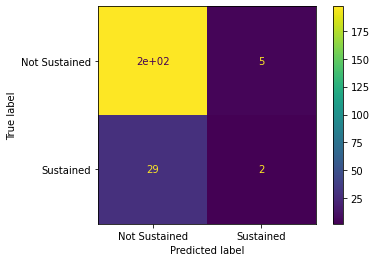

In [61]:
#Creating the classification model (1)

#Creating X and y dataframes

#Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.20, random_state = 11)                                                      

#Importing class

#Defining model
model = GaussianNB()
nb_pred = model.fit(X_train,y_train).predict(X_test) 
print(classification_report(y_test,nb_pred,digits = 3))

#Confusion matrix
cm = confusion_matrix(y_test,nb_pred) 
target_names = ['Not Sustained','Sustained']
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
display_cm.plot()


In [ ]:
# KNN


In [ ]:
# Random forest classifier